<h1>Titanic Classification Model Comparison

Project ini bertujuan untuk membangun dan membandingkan beberapa model machine learning guna memprediksi survival rate penumpang Titanic.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/Titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/Titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<h1> Exploratory Data Analysis - EDA

- train_df.info(): Menampilkan ringkasan DataFrame, termasuk tipe data setiap kolom dan jumlah nilai non-null. Dari sini, teridentifikasi adanya nilai yang hilang (missing values) pada kolom Age, Cabin, dan Embarked.

- train_df.Survived.value_counts(): Anda memeriksa distribusi dari variabel target (Survived). Ditemukan bahwa data tidak seimbang (imbalanced), di mana jumlah penumpang yang tidak selamat (label 0) lebih banyak (549) daripada yang selamat (label 1) (342). Ini menjadi justifikasi penggunaan teknik seperti SMOTE di kemudian hari.

- train_df.isna().sum(): Perintah ini secara spesifik menghitung jumlah nilai null di setiap kolom, mengonfirmasi bahwa Age memiliki 177 nilai hilang, Cabin memiliki 687, dan Embarked memiliki 2.

- train_df.duplicated().sum(): Memastikan tidak ada baris data yang terduplikasi di dalam dataset.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.Survived.value_counts()

,count
Survived,
0,549
1,342


In [ ]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
print("Jumlah duplikasi: ", train_df.duplicated().sum())

Jumlah duplikasi:  0


<h1>Data Preprocessing & Feature Engineering

1. Handling Missing Values:
    - Kolom Age: Nilai yang hilang diisi dengan nilai median (nilai tengah) dari usia seluruh penumpang. Median dipilih karena lebih robust terhadap outlier dibandingkan mean (rata-rata).
    - Kolom Embarked: Dua nilai yang hilang diisi dengan modus (nilai yang paling sering muncul) dari kolom tersebut.
    - Kolom Cabin: Kolom ini dihapus (drop) karena memiliki terlalu banyak nilai yang hilang (687 dari 891), sehingga sulit untuk diimputasi secara akurat.

2. Delete Unrelevant Column:
    - Kolom PassengerId, Name, dan Ticket dihapus karena merupakan identifier unik yang umumnya tidak memiliki kekuatan prediktif.

3. Encoding Fitur Kategorikal:
    - Label Encoding: Kolom Sex diubah dari teks ('male', 'female') menjadi numerik (1, 0) menggunakan LabelEncoder.
    - Feature Binning: Kolom Age yang kontinu dikelompokkan menjadi beberapa kategori (Age_Group) menggunakan pd.cut. Ini membantu model menangkap pola non-linear terkait usia.
    - One-Hot Encoding: Kolom kategorikal seperti Pclass, Embarked, dan Age_Group yang baru dibuat diubah menjadi beberapa kolom biner menggunakan pd.get_dummies. Setiap kategori menjadi kolom baru dengan nilai 0 atau 1.

4. Menghapus Kolom Redundan: Kolom Fare dihapus setelah proses feature engineering di atas.

In [ ]:
train_df[train_df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [ ]:
train_df['Age'] = train_df['Age'].fillna(round(train_df['Age'].median()))
test_df['Age'] = test_df['Age'].fillna(round(test_df['Age'].median()))

In [ ]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

In [ ]:
train_df = train_df.drop(columns=['Cabin'])
test_df = test_df.drop(columns=['Cabin'])

In [ ]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
test_df.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,1
Embarked,0


In [ ]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,646
mean,446.000000,0.383838,2.308642,NaN,NaN,29.361582,0.523008,0.381594,NaN,32.204208,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.019697,1.102743,0.806057,NaN,49.693429,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN


In [ ]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418,417.000000,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,3
top,NaN,NaN,"Peter, Master. Michael J",male,NaN,NaN,NaN,PC 17608,NaN,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,270
mean,1100.500000,2.265550,NaN,NaN,29.599282,0.447368,0.392344,NaN,35.627188,NaN
std,120.810458,0.841838,NaN,NaN,12.703770,0.896760,0.981429,NaN,55.907576,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN
25%,996.250000,1.000000,NaN,NaN,23.000000,0.000000,0.000000,NaN,7.895800,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,1204.750000,3.000000,NaN,NaN,35.750000,1.000000,0.000000,NaN,31.500000,NaN


In [ ]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket'])
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

label_encoder = LabelEncoder()
train_df['Sex'] = label_encoder.fit_transform(train_df['Sex'])

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False)
age_group_survival_rate = train_df.groupby('Age_Group')['Survived'].mean()

train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels)

train_df = pd.get_dummies(train_df, columns=['Pclass', 'Embarked', 'Age_Group'])
train_df = train_df.drop(columns=['Fare'])

categorical_features = train_df.select_dtypes(include=['object']).columns
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature])
    label_encoders[feature] = le

train_df

<ipython-input-500-4ca117311102>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_survival_rate = train_df.groupby('Age_Group')['Survived'].mean()


,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_Group_0-10,Age_Group_11-20,Age_Group_21-30,Age_Group_31-40,Age_Group_41-50,Age_Group_51-60,Age_Group_61-70,Age_Group_71-80
0,0,1,22.0,1,0,False,False,True,False,False,True,False,False,True,False,False,False,False,False
1,1,0,38.0,1,0,True,False,False,True,False,False,False,False,False,True,False,False,False,False
2,1,0,26.0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,False,False
3,1,0,35.0,1,0,True,False,False,False,False,True,False,False,False,True,False,False,False,False
4,0,1,35.0,0,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,27.0,0,0,False,True,False,False,False,True,False,False,True,False,False,False,False,False
887,1,0,19.0,0,0,True,False,False,False,False,True,False,True,False,False,False,False,False,False
888,0,0,28.0,1,2,False,False,True,False,False,True,False,False,True,False,False,False,False,False
889,1,1,26.0,0,0,True,False,False,True,False,False,False,False,True,False,False,False,False,False


<h1>Modeling Preparation

1. Pemisahan Fitur dan Target: DataFrame dibagi menjadi X (fitur-fitur prediktor) dan y (kolom target, yaitu Survived).

2. Pemisahan Data Latih dan Uji (train_test_split): Data dibagi menjadi set pelatihan (70%) dan set pengujian (30%). random_state=42 digunakan untuk memastikan hasil pembagian data selalu sama setiap kali kode dijalankan.

3. Penanganan Ketidakseimbangan Kelas (SMOTE):
    - SMOTE (Synthetic Minority Over-sampling Technique) diterapkan pada data latih (X_train, y_train).
    - Tujuannya adalah untuk menyeimbangkan distribusi kelas dengan cara membuat sampel sintetis untuk kelas minoritas (penumpang yang selamat). Hal ini dilakukan hanya pada data latih untuk mencegah kebocoran data (data leakage) ke set pengujian.

In [ ]:
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

<h1>Training and Model Evaluation

1. Pemilihan Model:
    - Decision Tree
    - Random Forest
    - AdaBoost
    - Bagging

2. Fungsi Evaluasi (evaluate_model):
    - Cross-validation: Menggunakan StratifiedKFold dengan 5 splits untuk mendapatkan estimasi performa yang lebih stabil.
    - Pelatihan Model: Melatih model pada data X_train_smote dan y_train_smote.
    - Prediksi: Membuat prediksi pada data X_test.
    - Perhitungan Metrik: Menghitung accuracy, precision, recall, f1-score, dan ROC-AUC.
    - Confusion Matrix: Menghasilkan confusion matrix untuk analisis true/false positives/negatives.

3. Hasil dan Analisis:
    - Setiap model dievaluasi, dan hasilnya (termasuk Classification Report dan Confusion Matrix) dicetak.
    - AdaBoost memiliki False Positives (FP) dan False Negatives (FN) terendah, menunjukkan performa yang paling seimbang dan akurat.
    - Random Forest juga menunjukkan performa yang baik, sedikit di bawah AdaBoost.
    - Decision Tree memiliki performa terendah, terutama dalam hal recall untuk kelas yang selamat.

4. AdaBoost adalah model terbaik di hampir semua metrik.

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Bagging" : BaggingClassifier(DecisionTreeClassifier(), n_estimators = 10, random_state=42),
}

Train Model

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

def evaluate_model(model, X_train, y_train, X_test, y_test, cv):
    # Cross-val
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    # Train model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if hasattr(model, "predict_proba") else None
    f1 = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)

    return {
        "cv_mean": np.mean(cv_scores),
        "cv_std": np.std(cv_scores),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "f1": f1,
        "confusion_matrix": cm
    }



Decision Tree Performance:
Cross-validation Accuracy: 0.807 ± 0.033
Accuracy: 0.761
Precision: 0.733
Recall: 0.667
F1-Score: 0.698
ROC-AUC: 0.724


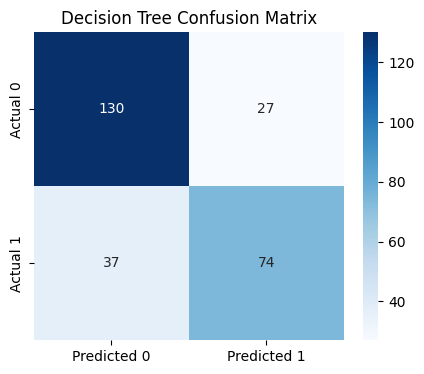


Random Forest Performance:
Cross-validation Accuracy: 0.827 ± 0.011
Accuracy: 0.784
Precision: 0.752
Recall: 0.712
F1-Score: 0.731
ROC-AUC: 0.859


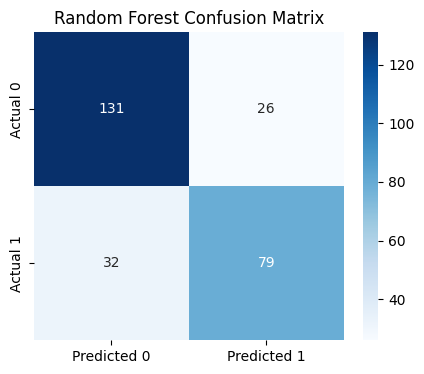


AdaBoost Performance:
Cross-validation Accuracy: 0.822 ± 0.041
Accuracy: 0.817
Precision: 0.792
Recall: 0.757
F1-Score: 0.774
ROC-AUC: 0.865


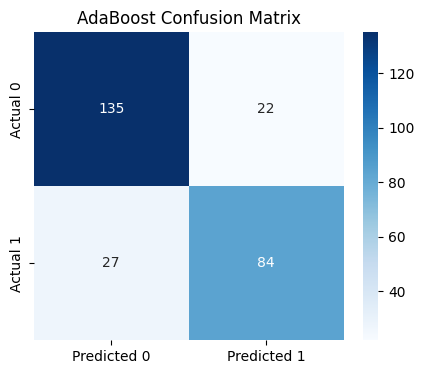


Bagging Performance:
Cross-validation Accuracy: 0.819 ± 0.015
Accuracy: 0.772
Precision: 0.750
Recall: 0.676
F1-Score: 0.711
ROC-AUC: 0.849


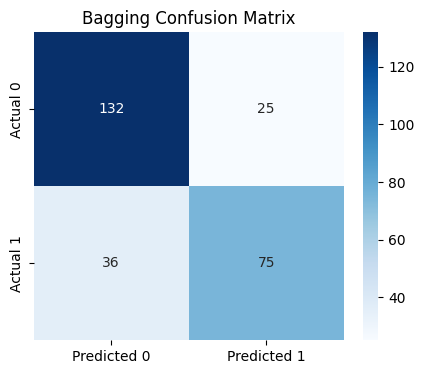

In [ ]:
for name, model in models.items():
    results[name] = evaluate_model(model, X_train_smote, y_train_smote, X_test, y_test, cv)

for name, result in results.items():
    print(f"\n{name} Performance:")
    print(f"Cross-validation Accuracy: {result['cv_mean']:.3f} ± {result['cv_std']:.3f}")
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"Precision: {result['precision']:.3f}")
    print(f"Recall: {result['recall']:.3f}")
    print(f"F1-Score: {result['f1']:.3f}")
    if result['roc_auc'] is not None:
        print(f"ROC-AUC: {result['roc_auc']:.3f}")

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{name} Confusion Matrix')
    plt.show()


# **Berdasarkan confussion matrix didapat bahwa:**

1. Decision Tree
- High FP (27): Terlalu banyak memprediksi penumpang selamat (padahal tidak).
- High FN (37): Banyak penumpang yang selamat salah diprediksi sebagai tidak selamat.
- Class Imbalance Impact: Struggles with minority class (survived).

2. Random Forest
- Reduced FN by 5: Lebih baik dalam mengidentifikasi penumpang yang benar-benar selamat.
- Higher TP (79): Lebih banyak penumpang selamat terprediksi dengan benar.
- FP (26) :  Masih ada over-prediksi keselamatan, tetapi lebih baik daripada Decision Tree.


3. AdaBoost

- Lowest FP (22): Paling sedikit memprediksi penumpang tidak selamat sebagai selamat.
- Lowest FN (27): Paling baik dalam menemukan penumpang selamat yang sebenarnya.
- Balanced: Precision dan recall sama-sama optimal.


4. Bagging
- Higher FN (36): Lebih buruk daripada AdaBoost/Random Forest dalam menemukan penumpang selamat.
- FP (25): Lebih baik daripada Decision Tree, tetapi tidak sebaik AdaBoost.


In [ ]:
results = {}
for name, model in models.items():
    # Cross val
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')

    # Train and predict
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results[name] = {
        'CV Mean Accuracy': np.mean(cv_scores),
        'CV Std': np.std(cv_scores),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'f1': f1,
        'Confusion Matrix': cm,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Classification Report': classification_report(y_test, y_pred)
    }


print("\n\nCLASSIFICATION REPORTS FOR EACH MODEL:")
print("-"*60)
for model_name in results.keys():
    print(f"\n{model_name} Classification Report:")
    print(results[model_name]['Classification Report'])
    print("-"*60)



CLASSIFICATION REPORTS FOR EACH MODEL:
------------------------------------------------------------

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       157
           1       0.73      0.67      0.70       111

    accuracy                           0.76       268
   macro avg       0.76      0.75      0.75       268
weighted avg       0.76      0.76      0.76       268

------------------------------------------------------------

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.71      0.73       111

    accuracy                           0.78       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.78      0.78      0.78       268

------------------------------------------------------------

AdaBoost Classification Report:
             

In [ ]:
# Compare model performances
metrics_df = pd.DataFrame.from_dict(results, orient='index')
metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
metrics_df = metrics_df.sort_values(by='accuracy', ascending=False)

print("\nModel Performance Comparison:")
print(metrics_df)


Model Performance Comparison:
               accuracy  precision    recall        f1   roc_auc
AdaBoost       0.817164   0.792453  0.756757  0.774194  0.865496
Random Forest  0.783582   0.752381  0.711712  0.731481  0.859012
Bagging        0.772388   0.750000  0.675676  0.710900  0.849314
Decision Tree  0.761194   0.732673  0.666667  0.698113  0.724164


<h1>ROC Curve Visualization

- ROC Curve memvisualisasikan kemampuan sebuah model untuk membedakan antara kelas positif dan negatif pada berbagai ambang batas.

- AUC (Area Under the Curve) yang lebih tinggi (mendekati 1.0) menunjukkan model yang lebih baik.

- ROC Curve memvalidasi bahwa AdaBoost (AUC = 0.87) dan Random Forest (AUC = 0.86) adalah dua model dengan performa terbaik.

- Adaboost terbaik dalam hal accuracy (mengurangi false alarm)
- Random forest lebih stabil dan tahan over fitting
- Decision Tree adalah model yang paling jelek karena tidak bisa membedakan kelas dengan baik
- Bagging digunakan hanya jika komputasi terbatas (lebih cepat daripada AdaBoost)

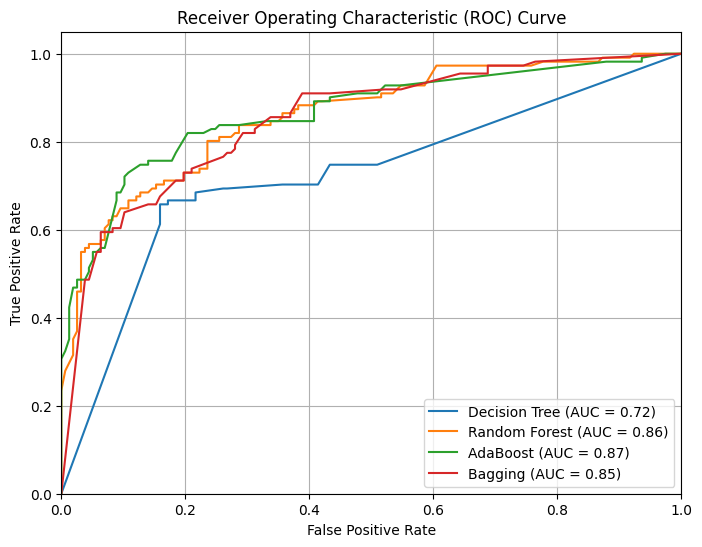

In [ ]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        model.fit(X_train_smote, y_train_smote)

        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Kesimpulan Akhir :**
Model Terbaik: AdaBoost

Confusion Matrix:

FP = 22 (paling rendah) → sedikit "false alarm".

FN = 27 (paling rendah) → sedikit penumpang selamat yang terlewat.


Evaluation Metrics:

Akurasi (82%) & ROC-AUC (0.87) tertinggi.

Presisi (79%) dan Recall (76%) seimbang → prediksi lebih andal.

Kesimpulan: Model terbaik untuk memprediksi keselamatan penumpang Titanic adalah AdaBoostClassifier. Model ini memberikan akurasi tertinggi dan keseimbangan terbaik antara precision dan recall, menjadikannya pilihan yang paling andal untuk kasus penggunaan ini